<h1 div class='alert alert-success'><center> TPS-Set: Feature Engineering</center></h1>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/26480/logos/header.png?t=2021-04-09-00-57-05)

# <div class="alert alert-success">  1. IMPORTAÇÕES </div>

## 1.1. Bibliotecas 

In [85]:
import warnings
import random
import os
import gc
import shap
import torch

In [24]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb

In [25]:
from sklearn.metrics           import silhouette_samples, silhouette_score
from sklearn.model_selection   import train_test_split, KFold #, RepeatedStratifiedKFold, StratifiedKFold  
from sklearn                   import metrics
from sklearn.preprocessing     import QuantileTransformer, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.cluster           import KMeans

In [26]:
from yellowbrick.cluster       import KElbowVisualizer, SilhouetteVisualizer
from datetime                  import datetime
from GPUtil                    import showUtilization as gpu_usage
from psutil                    import virtual_memory

In [27]:
import xgboost                 as xgb

## 1.2. Funções

In [28]:
def jupyter_setting():
    
    %matplotlib inline
      
    #os.environ["WANDB_SILENT"] = "true" 
    #plt.style.use('bmh') 
    #plt.rcParams['figure.figsize'] = [20,15]
    #plt.rcParams['font.size']      = 13
     
    pd.options.display.max_columns = None
    #pd.set_option('display.expand_frame_repr', False)

    warnings.filterwarnings(action='ignore')
    warnings.simplefilter('ignore')
    warnings.filterwarnings('ignore')
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    warnings.filterwarnings('ignore', category=UserWarning)
    
    #pd.set_option('display.max_rows', 5)
    #pd.set_option('display.max_columns', 500)
    #pd.set_option('display.max_colwidth', None)

    icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
    #sns.palplot(sns.color_palette(icecream))
    
    return icecream

icecream = jupyter_setting()

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.rcParams['font.size'] = 12
    plt.title('Precision Recall vs threshold')
    plt.xlabel('Threshold')
    plt.legend(loc="lower left")
    
    plt.grid(True)

In [30]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], "b-", label="Precision")
    
    plt.rcParams['font.size'] = 12
    plt.title('Precision vs recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # plt.legend(loc="lower left")
    
    plt.grid(True)

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, "r-", label=label)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('XGBR ROC curve for TPS 09')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.grid(True)

In [32]:
def confusion_plot(matrix, labels = None, title = None):
    
    """ Exibir matriz de confusão binária como um mapa de calor Seaborn """
    plt.figure(figsize=(7,5))
    
    labels = labels if labels else ['Negative (0)', 'Positive (1)']
    
    #labels      = ['No Churn', 'Churn']
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    
    sns.heatmap(data        = matrix, 
                cmap        = 'Blues', 
                annot       = True, 
                fmt         = 'd',
                xticklabels = labels, 
                yticklabels = labels, 
                ax          = ax)
    
    ax.set_xlabel('\n PREVISTO', fontsize=15)
    ax.set_ylabel('REAL \n', fontsize=15)
    ax.set_title(title)
    
    plt.close()
    
    return fig;

In [33]:
def reduce_memory_usage(df, verbose=True):
    
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    
    for col in df.columns:
        
        col_type = df[col].dtypes
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
        
    return df

In [34]:
def diff(t_a, t_b):
    from dateutil.relativedelta import relativedelta
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

## 1.3. GPU

### 1.3.1. Informações

In [35]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov  2 19:29:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.06       Driver Version: 510.06       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   54C    P8    N/A /  N/A |    790MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 1.3.2. Memória

In [36]:
ram_gb = virtual_memory().total / 1e9

print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 17.0 gigabytes of available RAM

Not using a high-RAM runtime


In [37]:
!mkdir img
!mkdir Data
!mkdir Data/pkl
!mkdir Data/submission

!mkdir model
!mkdir model/preds
!mkdir model/optuna

!mkdir model/preds/test
!mkdir model/preds/test/n1
!mkdir model/preds/test/n2
!mkdir model/preds/test/n3

!mkdir model/preds/train
!mkdir model/preds/train/n1
!mkdir model/preds/train/n2
!mkdir model/preds/train/n3
!mkdir model/preds/param

J  existe uma subpasta ou um arquivo img.
J  existe uma subpasta ou um arquivo Data.
A sintaxe do comando est  incorreta.
A sintaxe do comando est  incorreta.
J  existe uma subpasta ou um arquivo model.
A sintaxe do comando est  incorreta.
A sintaxe do comando est  incorreta.
A sintaxe do comando est  incorreta.
A sintaxe do comando est  incorreta.
A sintaxe do comando est  incorreta.
A sintaxe do comando est  incorreta.
A sintaxe do comando est  incorreta.
A sintaxe do comando est  incorreta.
A sintaxe do comando est  incorreta.
A sintaxe do comando est  incorreta.
A sintaxe do comando est  incorreta.


## 1.4. Carregar Dados

In [39]:
path   = ''
target = 'target'

In [43]:
%%time
df1_train     = jb.load(path + 'Data/pkl/df1_nb_01_train.pkl.z')
df1_test      = jb.load(path + 'Data/pkl/df1_nb_01_test.pkl.z')
df_submission = pd.read_csv('Data/sample_submission.csv')

df1_train.drop('id', axis=1, inplace=True)
df1_test.drop('id', axis=1, inplace=True)

gc.collect()

df1_train.shape, df1_test.shape, df_submission.shape

Wall time: 2.51 s


((600000, 101), (540000, 100), (540000, 2))

In [44]:
df1_train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,target
0,0.106628,3.593750,132.7500,3.183594,0.081970,1.188477,3.732422,2.265625,2.099609,0.012329,1.607422,-0.318115,0.560059,2.806641,1.351562,2.535156,0.197510,0.676270,1.990234,-3.841797,0.037384,0.230347,3.330078,0.009399,0.144775,3.050781,1.303711,0.033234,-0.018280,2.748047,-0.009293,-0.036285,-0.049866,0.019485,3.898438,11.289062,1.137695,3.367188,4.945312,-0.105774,2.113281,3.453125,0.789551,1.113281,1.491211,2.439453,0.041809,3.355469,0.053680,1.701172,0.908691,0.094910,0.030212,0.597168,4.445312,1.586914,-0.068665,-0.108276,0.061035,0.046112,0.017105,-0.027557,0.019485,-0.048828,0.050751,3.728516,5.015625,4.187500,0.063354,0.121033,1.372070,4.015625,0.167603,0.039764,2.042969,-0.016617,0.107666,3.507812,0.013657,-0.097046,5.394531,0.244507,3.492188,0.113098,-0.015472,4.207031,4.105469,0.037231,-0.118835,0.067078,0.010742,1.098633,0.013329,-0.011719,0.052765,0.065430,4.210938,1.978516,0.085999,0.240479,0
1,0.125000,1.673828,76.5625,3.378906,0.099426,5.093750,1.275391,-0.471436,4.546875,0.037720,0.331787,0.325195,0.062042,2.261719,4.339844,-0.224976,0.233643,3.380859,1.903320,0.067871,-0.051270,0.006134,2.603516,0.103455,0.067627,4.753906,1.855469,-0.181885,0.008362,3.166016,0.011848,0.022293,0.069336,0.117126,0.315186,24.484375,1.671875,-0.409180,4.953125,0.092346,2.603516,1.955078,0.005898,3.289062,2.564453,0.817871,0.026001,4.617188,1.575195,0.066101,0.681641,0.025253,0.183472,0.110046,2.746094,0.835449,0.188232,4.960938,0.136108,-0.008492,-0.015266,-0.010841,0.064575,0.102539,0.093628,0.963867,0.630371,4.308594,0.091309,-0.036346,3.617188,3.103516,0.000657,0.051300,1.924805,0.123291,-0.022675,1.547852,-0.010399,0.058319,3.662109,-0.118408,2.357422,-0.009109,0.178711,4.097656,3.533203,0.005245,0.121399,0.109985,0.135864,3.460938,0.017059,0.124878,0.154053,0.606934,-0.267822,2.578125,-0.020874,0.024719,0
2,0.036316,1.497070,233.5000,2.195312,0.026917,3.126953,5.058594,3.849609,1.801758,0.057007,0.328613,2.968750,0.105225,2.070312,5.308594,1.354492,-0.261963,1.378906,1.480469,0.020538,-0.008804,0.109375,1.683594,0.038177,0.123718,1.112305,3.572266,0.120605,0.082092,2.234375,0.002270,0.045197,0.014404,0.011597,-0.502930,33.750000,1.417969,1.071289,3.222656,2.121094,3.082031,0.637695,-0.006821,-0.390869,17.343750,3.701172,-0.033600,1.578125,0.051971,-0.002005,2.691406,0.018372,-0.030472,0.111389,2.187500,-0.324951,-0.019943,3.455078,0.068115,-0.009811,-0.010628,0.027573,-0.007122,-0.048920,-0.002575,1.865234,2.404297,0.411621,0.057739,0.525391,2.167969,0.828125,0.089844,0.093750,4.949219,-0.010979,0.076660,0.266846,0.038696,0.382812,3.847656,-0.121460,3.740234,0.147095,-0.016571,0.614746,2.125000,0.078857,0.979980,0.026764,0.117310,4.882812,0.085205,0.032410,0.116089,-0.001689,-0.520020,2.140625,0.124451,0.148193,0
3,-0.014076,0.245972,780.0000,1.890625,0.006947,1.531250,2.697266,4.515625,4.503906,0.123474,1.002930,4.871094,0.058411,2.498047,1.238281,2.347656,0.175415,1.609375,2.029297,0.042084,0.005142,0.076477,1.651367,0.111816,0.121643,0.589355,4.238281,-0.032837,0.058167,0.712891,0.097473,0.072754,0.000324,0.063354,4.062500,25.375000,0.576660,2.025391,2.968750,1.085938,1.710938,1.372070,0.034637,0.722656,71.437500,3.035156,0.092224,3.453125,0.044830,0.027191,4.082031,0.046967,0.063721,0.029221,0.671875,0.185303,0.164307,3.804688,0.062317,-0.021408,0.009468,0.110901,0.026840,2.931641,0.068115,-0.495117,1.345703,2.242188,0.035614,-0.139282,4.742188,3.292969,0.117859,0.065613,0.556641,-0.058044,0.070496,1.101562,0.068542,0.162964,4.070312,-0.008835,3.896484,0.913574,-0.163208,3.074219,4.355469,-0.048889,4.917969,0.069946,-0.015350,3.4

# <div class="alert alert-success"> 2. Feature Engineering </div>

In [45]:
feature_num = df1_train.columns.to_list() 
feature_num.remove('target')

## 2.1. Step 01
Vamos fazer uma clusterização e gerar uma nova variável, isso pode ajudar na identificação de novos padrões e melhor a predição dos algoritmos, caso não surta efeito podemos remover a variável.    

In [46]:
%%time
scaler        = QuantileTransformer(output_distribution='normal', random_state=0)
df1_train_qt  = df1_train.copy().drop('target', axis=1) 
df1_train_qt  = pd.DataFrame(scaler.fit_transform(df1_train_qt), columns=feature_num)
df1_test_qt   = pd.DataFrame(scaler.fit_transform(df1_test), columns=feature_num)

Wall time: 37 s


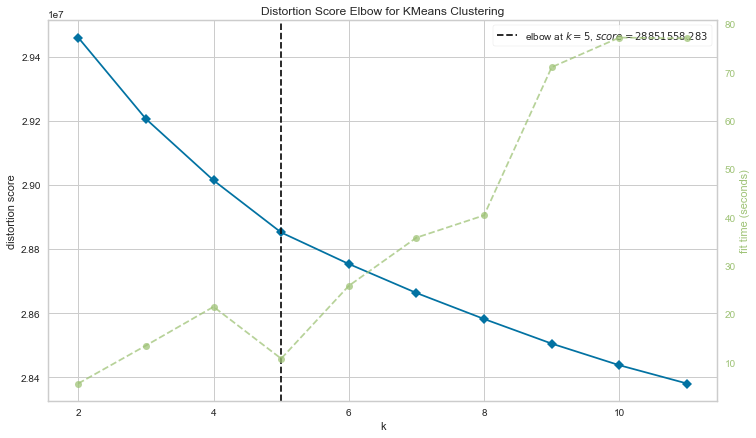

Wall time: 6min 28s


<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [47]:
%%time 
plt.figure(figsize=(12, 7))
visualizer_1 = KElbowVisualizer(KMeans(random_state=12359), k=(2,12))
visualizer_1.fit(df1_train_qt.head(300000));
visualizer_1.poof();

<div class="alert alert-info" role="alert">
    
**`NOTA:`** <br>

De acordo com o gráfico acima, podemos criar 5 clusteres nos datasets
    
    
</div>


In [48]:
model_kmeans = KMeans(n_clusters=5, random_state=59)
model_kmeans.fit(df1_train_qt);

clusters_train = model_kmeans.predict(df1_train_qt)
clusters_test  = model_kmeans.predict(df1_test_qt)

df1_train['fe_cluster'] = clusters_train
df1_test['fe_cluster']  = clusters_test

df1_train.shape, df1_test.shape

((600000, 102), (540000, 101))

In [52]:
df1_train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,target,fe_cluster_0,fe_cluster_1,fe_cluster_2,fe_cluster_3,fe_cluster_4
0,0.106628,3.593750,132.7500,3.183594,0.081970,1.188477,3.732422,2.265625,2.099609,0.012329,1.607422,-0.318115,0.560059,2.806641,1.351562,2.535156,0.197510,0.676270,1.990234,-3.841797,0.037384,0.230347,3.330078,0.009399,0.144775,3.050781,1.303711,0.033234,-0.018280,2.748047,-0.009293,-0.036285,-0.049866,0.019485,3.898438,11.289062,1.137695,3.367188,4.945312,-0.105774,2.113281,3.453125,0.789551,1.113281,1.491211,2.439453,0.041809,3.355469,0.053680,1.701172,0.908691,0.094910,0.030212,0.597168,4.445312,1.586914,-0.068665,-0.108276,0.061035,0.046112,0.017105,-0.027557,0.019485,-0.048828,0.050751,3.728516,5.015625,4.187500,0.063354,0.121033,1.372070,4.015625,0.167603,0.039764,2.042969,-0.016617,0.107666,3.507812,0.013657,-0.097046,5.394531,0.244507,3.492188,0.113098,-0.015472,4.207031,4.105469,0.037231,-0.118835,0.067078,0.010742,1.098633,0.013329,-0.011719,0.052765,0.065430,4.210938,1.978516,0.085999,0.240479,0,0,1,0,0,0
1,0.125000,1.673828,76.5625,3.378906,0.099426,5.093750,1.275391,-0.471436,4.546875,0.037720,0.331787,0.325195,0.062042,2.261719,4.339844,-0.224976,0.233643,3.380859,1.903320,0.067871,-0.051270,0.006134,2.603516,0.103455,0.067627,4.753906,1.855469,-0.181885,0.008362,3.166016,0.011848,0.022293,0.069336,0.117126,0.315186,24.484375,1.671875,-0.409180,4.953125,0.092346,2.603516,1.955078,0.005898,3.289062,2.564453,0.817871,0.026001,4.617188,1.575195,0.066101,0.681641,0.025253,0.183472,0.110046,2.746094,0.835449,0.188232,4.960938,0.136108,-0.008492,-0.015266,-0.010841,0.064575,0.102539,0.093628,0.963867,0.630371,4.308594,0.091309,-0.036346,3.617188,3.103516,0.000657,0.051300,1.924805,0.123291,-0.022675,1.547852,-0.010399,0.058319,3.662109,-0.118408,2.357422,-0.009109,0.178711,4.097656,3.533203,0.005245,0.121399,0.109985,0.135864,3.460938,0.017059,0.124878,0.154053,0.606934,-0.267822,2.578125,-0.020874,0.024719,0,0,1,0,0,0
2,0.036316,1.497070,233.5000,2.195312,0.026917,3.126953,5.058594,3.849609,1.801758,0.057007,0.328613,2.968750,0.105225,2.070312,5.308594,1.354492,-0.261963,1.378906,1.480469,0.020538,-0.008804,0.109375,1.683594,0.038177,0.123718,1.112305,3.572266,0.120605,0.082092,2.234375,0.002270,0.045197,0.014404,0.011597,-0.502930,33.750000,1.417969,1.071289,3.222656,2.121094,3.082031,0.637695,-0.006821,-0.390869,17.343750,3.701172,-0.033600,1.578125,0.051971,-0.002005,2.691406,0.018372,-0.030472,0.111389,2.187500,-0.324951,-0.019943,3.455078,0.068115,-0.009811,-0.010628,0.027573,-0.007122,-0.048920,-0.002575,1.865234,2.404297,0.411621,0.057739,0.525391,2.167969,0.828125,0.089844,0.093750,4.949219,-0.010979,0.076660,0.266846,0.038696,0.382812,3.847656,-0.121460,3.740234,0.147095,-0.016571,0.614746,2.125000,0.078857,0.979980,0.026764,0.117310,4.882812,0.085205,0.032410,0.116089,-0.001689,-0.520020,2.140625,0.124451,0.148193,0,0,0,0,1,0
3,-0.014076,0.245972,780.0000,1.890625,0.006947,1.531250,2.697266,4.515625,4.503906,0.123474,1.002930,4.871094,0.058411,2.498047,1.238281,2.347656,0.175415,1.609375,2.029297,0.042084,0.005142,0.076477,1.651367,0.111816,0.121643,0.589355,4.238281,-0.032837,0.058167,0.712891,0.097473,0.072754,0.000324,0.063354,4.062500,25.375000,0.576660,2.025391,2.968750,1.085938,1.710938,1.372070,0.034637,0.722656,71.437500,3.035156,0.092224,3.453125,0.044830,0.027191,4.082031,0.046967,0.063721,0.029221,0.671875,0.185303,0.164307,3.804688,0.062317,-0.021408,0.009468,0.110901,0.026840,2.931641,0.068115,-0.495117,1.345703,2.242188,0.035614,-0.139282,4.742188,3.292969,0.117859,0.065613,0.556641,-0.058044,0.070496,1.101562,0.068542,0.162964,4.070312,-0

<div class="alert alert-info" role="alert">
    
**`NOTA:`** <br>
Vamos transforma a cluster em dammy.
    
    
</div>


In [ ]:
df1_train = pd.get_dummies(df1_train, columns=['fe_cluster'])
df1_test = pd.get_dummies(df1_test, columns=['fe_cluster'])

df1_train.shape, df1_test.shape

In [54]:
df1_train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,target,fe_cluster_0,fe_cluster_1,fe_cluster_2,fe_cluster_3,fe_cluster_4
0,0.106628,3.593750,132.7500,3.183594,0.081970,1.188477,3.732422,2.265625,2.099609,0.012329,1.607422,-0.318115,0.560059,2.806641,1.351562,2.535156,0.197510,0.676270,1.990234,-3.841797,0.037384,0.230347,3.330078,0.009399,0.144775,3.050781,1.303711,0.033234,-0.018280,2.748047,-0.009293,-0.036285,-0.049866,0.019485,3.898438,11.289062,1.137695,3.367188,4.945312,-0.105774,2.113281,3.453125,0.789551,1.113281,1.491211,2.439453,0.041809,3.355469,0.053680,1.701172,0.908691,0.094910,0.030212,0.597168,4.445312,1.586914,-0.068665,-0.108276,0.061035,0.046112,0.017105,-0.027557,0.019485,-0.048828,0.050751,3.728516,5.015625,4.187500,0.063354,0.121033,1.372070,4.015625,0.167603,0.039764,2.042969,-0.016617,0.107666,3.507812,0.013657,-0.097046,5.394531,0.244507,3.492188,0.113098,-0.015472,4.207031,4.105469,0.037231,-0.118835,0.067078,0.010742,1.098633,0.013329,-0.011719,0.052765,0.065430,4.210938,1.978516,0.085999,0.240479,0,0,1,0,0,0
1,0.125000,1.673828,76.5625,3.378906,0.099426,5.093750,1.275391,-0.471436,4.546875,0.037720,0.331787,0.325195,0.062042,2.261719,4.339844,-0.224976,0.233643,3.380859,1.903320,0.067871,-0.051270,0.006134,2.603516,0.103455,0.067627,4.753906,1.855469,-0.181885,0.008362,3.166016,0.011848,0.022293,0.069336,0.117126,0.315186,24.484375,1.671875,-0.409180,4.953125,0.092346,2.603516,1.955078,0.005898,3.289062,2.564453,0.817871,0.026001,4.617188,1.575195,0.066101,0.681641,0.025253,0.183472,0.110046,2.746094,0.835449,0.188232,4.960938,0.136108,-0.008492,-0.015266,-0.010841,0.064575,0.102539,0.093628,0.963867,0.630371,4.308594,0.091309,-0.036346,3.617188,3.103516,0.000657,0.051300,1.924805,0.123291,-0.022675,1.547852,-0.010399,0.058319,3.662109,-0.118408,2.357422,-0.009109,0.178711,4.097656,3.533203,0.005245,0.121399,0.109985,0.135864,3.460938,0.017059,0.124878,0.154053,0.606934,-0.267822,2.578125,-0.020874,0.024719,0,0,1,0,0,0
2,0.036316,1.497070,233.5000,2.195312,0.026917,3.126953,5.058594,3.849609,1.801758,0.057007,0.328613,2.968750,0.105225,2.070312,5.308594,1.354492,-0.261963,1.378906,1.480469,0.020538,-0.008804,0.109375,1.683594,0.038177,0.123718,1.112305,3.572266,0.120605,0.082092,2.234375,0.002270,0.045197,0.014404,0.011597,-0.502930,33.750000,1.417969,1.071289,3.222656,2.121094,3.082031,0.637695,-0.006821,-0.390869,17.343750,3.701172,-0.033600,1.578125,0.051971,-0.002005,2.691406,0.018372,-0.030472,0.111389,2.187500,-0.324951,-0.019943,3.455078,0.068115,-0.009811,-0.010628,0.027573,-0.007122,-0.048920,-0.002575,1.865234,2.404297,0.411621,0.057739,0.525391,2.167969,0.828125,0.089844,0.093750,4.949219,-0.010979,0.076660,0.266846,0.038696,0.382812,3.847656,-0.121460,3.740234,0.147095,-0.016571,0.614746,2.125000,0.078857,0.979980,0.026764,0.117310,4.882812,0.085205,0.032410,0.116089,-0.001689,-0.520020,2.140625,0.124451,0.148193,0,0,0,0,1,0
3,-0.014076,0.245972,780.0000,1.890625,0.006947,1.531250,2.697266,4.515625,4.503906,0.123474,1.002930,4.871094,0.058411,2.498047,1.238281,2.347656,0.175415,1.609375,2.029297,0.042084,0.005142,0.076477,1.651367,0.111816,0.121643,0.589355,4.238281,-0.032837,0.058167,0.712891,0.097473,0.072754,0.000324,0.063354,4.062500,25.375000,0.576660,2.025391,2.968750,1.085938,1.710938,1.372070,0.034637,0.722656,71.437500,3.035156,0.092224,3.453125,0.044830,0.027191,4.082031,0.046967,0.063721,0.029221,0.671875,0.185303,0.164307,3.804688,0.062317,-0.021408,0.009468,0.110901,0.026840,2.931641,0.068115,-0.495117,1.345703,2.242188,0.035614,-0.139282,4.742188,3.292969,0.117859,0.065613,0.556641,-0.058044,0.070496,1.101562,0.068542,0.162964,4.070312,-0

## 2.2. Step 02

In [55]:
%%time 

df1_train['fe_mean']   = df1_train[feature_num].mean(axis=1)
df1_test['fe_mean']    = df1_test[feature_num].mean(axis=1)
df1_train['fe_median'] = df1_train[feature_num].median(axis=1)
df1_test['fe_median']  = df1_test[feature_num].median(axis=1)
df1_train['fe_min']    = df1_train[feature_num].min(axis=1)
df1_test['fe_min']     = df1_test[feature_num].min(axis=1)
df1_train['fe_max']    = df1_train[feature_num].max(axis=1)
df1_test['fe_max']     = df1_test[feature_num].max(axis=1)
df1_train['fe_skew']   = df1_train[feature_num].skew(axis=1)
df1_test['fe_skew']    = df1_test[feature_num].skew(axis=1)
#df1_train['fe_var']   = df1_train[feature_num].var(axis=1)
#df1_test['fe_var']    = df1_test[feature_num].var(axis=1)

gc.collect()

df1_train.shape, df1_test.shape

Wall time: 22.8 s


((600000, 112), (540000, 111))

In [56]:
df1_train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,target,fe_cluster_0,fe_cluster_1,fe_cluster_2,fe_cluster_3,fe_cluster_4,fe_mean,fe_median,fe_min,fe_max,fe_skew,fe_var
0,0.106628,3.593750,132.7500,3.183594,0.081970,1.188477,3.732422,2.265625,2.099609,0.012329,1.607422,-0.318115,0.560059,2.806641,1.351562,2.535156,0.197510,0.676270,1.990234,-3.841797,0.037384,0.230347,3.330078,0.009399,0.144775,3.050781,1.303711,0.033234,-0.018280,2.748047,-0.009293,-0.036285,-0.049866,0.019485,3.898438,11.289062,1.137695,3.367188,4.945312,-0.105774,2.113281,3.453125,0.789551,1.113281,1.491211,2.439453,0.041809,3.355469,0.053680,1.701172,0.908691,0.094910,0.030212,0.597168,4.445312,1.586914,-0.068665,-0.108276,0.061035,0.046112,0.017105,-0.027557,0.019485,-0.048828,0.050751,3.728516,5.015625,4.187500,0.063354,0.121033,1.372070,4.015625,0.167603,0.039764,2.042969,-0.016617,0.107666,3.507812,0.013657,-0.097046,5.394531,0.244507,3.492188,0.113098,-0.015472,4.207031,4.105469,0.037231,-0.118835,0.067078,0.010742,1.098633,0.013329,-0.011719,0.052765,0.065430,4.210938,1.978516,0.085999,0.240479,0,0,1,0,0,0,2.650391,0.242432,-3.841797,132.7500,9.687500,176.3750
1,0.125000,1.673828,76.5625,3.378906,0.099426,5.093750,1.275391,-0.471436,4.546875,0.037720,0.331787,0.325195,0.062042,2.261719,4.339844,-0.224976,0.233643,3.380859,1.903320,0.067871,-0.051270,0.006134,2.603516,0.103455,0.067627,4.753906,1.855469,-0.181885,0.008362,3.166016,0.011848,0.022293,0.069336,0.117126,0.315186,24.484375,1.671875,-0.409180,4.953125,0.092346,2.603516,1.955078,0.005898,3.289062,2.564453,0.817871,0.026001,4.617188,1.575195,0.066101,0.681641,0.025253,0.183472,0.110046,2.746094,0.835449,0.188232,4.960938,0.136108,-0.008492,-0.015266,-0.010841,0.064575,0.102539,0.093628,0.963867,0.630371,4.308594,0.091309,-0.036346,3.617188,3.103516,0.000657,0.051300,1.924805,0.123291,-0.022675,1.547852,-0.010399,0.058319,3.662109,-0.118408,2.357422,-0.009109,0.178711,4.097656,3.533203,0.005245,0.121399,0.109985,0.135864,3.460938,0.017059,0.124878,0.154053,0.606934,-0.267822,2.578125,-0.020874,0.024719,0,0,1,0,0,0,2.136719,0.145020,-0.471436,76.5625,8.429688,64.4375
2,0.036316,1.497070,233.5000,2.195312,0.026917,3.126953,5.058594,3.849609,1.801758,0.057007,0.328613,2.968750,0.105225,2.070312,5.308594,1.354492,-0.261963,1.378906,1.480469,0.020538,-0.008804,0.109375,1.683594,0.038177,0.123718,1.112305,3.572266,0.120605,0.082092,2.234375,0.002270,0.045197,0.014404,0.011597,-0.502930,33.750000,1.417969,1.071289,3.222656,2.121094,3.082031,0.637695,-0.006821,-0.390869,17.343750,3.701172,-0.033600,1.578125,0.051971,-0.002005,2.691406,0.018372,-0.030472,0.111389,2.187500,-0.324951,-0.019943,3.455078,0.068115,-0.009811,-0.010628,0.027573,-0.007122,-0.048920,-0.002575,1.865234,2.404297,0.411621,0.057739,0.525391,2.167969,0.828125,0.089844,0.093750,4.949219,-0.010979,0.076660,0.266846,0.038696,0.382812,3.847656,-0.121460,3.740234,0.147095,-0.016571,0.614746,2.125000,0.078857,0.979980,0.026764,0.117310,4.882812,0.085205,0.032410,0.116089,-0.001689,-0.520020,2.140625,0.124451,0.148193,0,0,0,0,1,0,3.814453,0.124084,-0.520020,233.5000,9.609375,553.5000
3,-0.014076,0.245972,780.0000,1.890625,0.006947,1.531250,2.697266,4.515625,4.503906,0.123474,1.002930,4.871094,0.058411,2.498047,1.238281,2.347656,0.175415,1.609375,2.029297,0.042084,0.005142,0.076477,1.651367,0.111816,0.121643,0.589355,4.238281,-0.032837,0.058167,0.712891,0.097473,0.072754,0.000324,0.063354,4.062500,25.375000,0.576660,2.025391,2.968750,1.085938,1.710938,1.372070,0.034637,0.722656,71.437500,3.035156,0.092224,3.453125,0.044830,0.027191,4.082031,0.046967,0.063721,0.029221,0.671875,0.185303,0.164307,3.804688,0.0

Vamos salvar os dataset, caso seja necessário refazer o processo podemos partir desse ponto. 

In [57]:
jb.dump(df1_train,  "Data/pkl/df2_nb_02_train.pkl.z")
jb.dump(df1_test,  "Data/pkl/df2_nb_02_test.pkl.z")

gc.collect()

0

# <div class="alert alert-success"> 3. Split Train/Test </div>

In [71]:
df2_train = jb.load('Data/pkl/df2_nb_02_train.pkl.z')
df2_test  = jb.load('Data/pkl/df2_nb_02_test.pkl.z')

df2_train.shape, df2_test.shape

((600000, 111), (540000, 110))

In [59]:
print(feature_num)

['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99']


In [72]:
X      = df2_train.drop(['target'], axis=1)
y      = df2_train['target']
X_test = df2_test

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.2,
                                                      shuffle      = True, 
                                                      stratify     = y,
                                                      random_state = 0)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape 

((480000, 110), (480000,), (120000, 110), (120000,))

In [75]:
X_test.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,fe_cluster_0,fe_cluster_1,fe_cluster_2,fe_cluster_3,fe_cluster_4,fe_mean,fe_median,fe_min,fe_max,fe_skew
0,0.003229,4.839844,585.5000,2.283203,0.713379,3.908203,0.480713,1.482422,4.890625,0.056335,4.199219,3.152344,0.000349,1.851562,2.638672,0.746582,-0.004757,1.610352,4.113281,-0.077759,0.129395,0.053314,0.416748,0.445068,0.150513,5.019531,2.220703,-0.072327,-0.215820,1.562500,0.074890,0.010048,0.018585,0.067444,5.578125,3.085938,3.841797,0.011124,2.359375,0.695312,-0.345703,4.386719,0.054932,2.802734,3.873047,3.974609,0.157837,0.704590,-0.001125,-0.004547,1.010742,0.094482,0.016937,0.100891,4.367188,1.832031,0.019684,1.963867,0.120605,0.080261,0.027512,0.048828,0.074646,0.041260,0.069336,4.250000,2.091797,0.694824,0.007465,-0.017883,1.883789,1.267578,0.023743,0.043060,3.173828,0.074341,0.125854,3.925781,0.046906,-0.042297,3.019531,0.089539,3.201172,0.009682,-0.099670,3.572266,4.796875,0.091980,0.773438,0.073364,0.112915,1.073242,0.122131,0.086304,0.036011,0.010620,0.290283,1.898438,0.131592,0.012047,1,0,0,0,0,7.078125,0.154175,-0.345703,585.500000,9.992188
1,0.008598,0.505371,-100.1250,3.011719,0.027206,1.194336,5.035156,2.517578,4.554688,0.063904,0.337158,4.441406,0.013191,3.378906,3.384766,1.166992,2.246094,1.750000,2.765625,-0.058502,0.012596,0.036133,0.769043,0.017502,0.050293,0.324707,4.949219,0.124817,0.347168,1.245117,0.035828,-0.013191,0.023193,0.006443,4.984375,23.703125,8.289062,4.796875,1.798828,-0.050049,1.973633,1.912109,0.035980,2.572266,6.320312,0.442627,0.148071,1.311523,0.106689,0.625977,2.310547,-0.044342,0.194336,0.131470,4.265625,0.715820,0.017120,2.839844,0.104736,-0.007950,0.067627,0.066467,0.034271,0.605957,0.019989,-0.456787,3.378906,1.900391,0.052307,-0.050385,2.613281,3.113281,0.022308,0.108337,4.617188,0.091431,0.039368,3.035156,1.023438,-0.020584,2.771484,3.308594,5.058594,-0.003994,0.067627,0.995605,2.470703,-0.015213,0.263428,-0.021912,-0.020218,2.623047,0.123291,0.033051,0.123047,0.005772,-0.392822,3.689453,0.047424,0.119995,0,0,1,0,0,0.551270,0.293945,-100.125000,23.703125,-8.796875
2,1.460938,2.437500,-112.9375,3.541016,0.752441,4.339844,1.648438,4.699219,1.950195,0.005302,2.072266,0.546387,0.141724,1.672852,4.304688,1.702148,-0.062866,1.619141,4.191406,0.055145,-0.016586,0.017807,3.064453,0.070374,0.098328,3.507812,1.069336,0.012749,0.009979,3.468750,0.035919,-0.009804,0.065735,-0.004726,5.281250,11.531250,0.171753,4.394531,2.521484,0.079346,5.453125,1.786133,0.029617,3.064453,5.277344,0.315918,0.148315,0.463135,-0.039948,0.150635,3.753906,0.024170,0.107483,0.048737,3.582031,0.966309,-0.058960,1.870117,0.029877,-0.044281,0.065186,-0.003328,-0.001950,0.095032,0.080261,3.337891,3.605469,4.695312,0.075623,-0.088257,1.772461,-0.142212,0.000918,0.021484,0.241821,0.067566,-0.026566,0.895020,0.111633,0.524414,1.450195,0.019348,1.271484,0.076050,0.447021,4.406250,2.447266,-0.041168,0.212402,0.140991,-0.011032,2.029297,-0.000426,0.084106,0.123596,0.499512,4.054688,3.330078,0.108826,0.064697,0,1,0,0,0,0.224365,0.192139,-112.937500,11.531250,-9.570312
3,0.140503,3.085938,179.5000,0.573730,0.057343,2.216797,1.623047,0.526367,1.542969,-0.026154,1.609375,1.723633,-0.019562,1.551758,4.832031,1.501953,0.192627,4.613281,1.470703,-0.010033,0.072815,0.048035,3.230469,-0.031555,0.028702,3.751953,4.949219,-0.174561,-0.033478,2.478516,0.068115,0.090820,0.029877,0.146729,3.169922,-12.984375,3.134766,1.764648,3.253906,0.713379,3.730469,2.652344,0.080933,1.056641,1.452148,1.814453,0.077881,2.720703,0.004532,0.108826,2.833984,0.024643,-0.051422,0.060577,3.419922,1.283203,-0.083191,0.048828,-0.002502,0.051392,0.075806,-0.008904,0.1417

In [62]:
del df2_train, df2_test
del df1_test_qt, df1_train_qt
del df1_train, df1_test

# <div class="alert alert-success"> 4. Modelagem </div>

In [73]:
seed   = 12359
params = {'objective'     : 'binary:logistic',    
          'eval_metric'   : 'auc',
          'random_state'  : seed}

if torch.cuda.is_available():           
    params.update({'predictor'  : 'gpu_predictor', 
                   'tree_method': 'gpu_hist', 
                   'gpu_id'     :  0})

params

{'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'random_state': 12359,
 'predictor': 'gpu_predictor',
 'tree_method': 'gpu_hist',
 'gpu_id': 0}

## 4.1. Validação Cruzada

In [76]:
def save_data_model(model_, model_name_, path_, X_train_prob_, y_hat_test_, score_, seed_, level_='1'):

    level_ = 'n'+ level_ + '/'

    if score_>.6:          

        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_)
        path_name_train = path_ + 'model/preds/train/' + level_ + model_name_.format(score_, seed_)
        path_name_test  = path_ + 'model/preds/test/'  + level_ + model_name_.format(score_, seed_)    
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_)    

        jb.dump(X_train_prob_, path_name_train)
        jb.dump(y_hat_test_, path_name_test)
        jb.dump(model_, path_name_model)
        jb.dump(pd.DataFrame([model_.get_params()]), path_name_param)   

        if score_>.65:
            # Gerar o arquivo de submissão 
            df_submission['target'] = y_hat_test_
            name_file_sub =  path_ + 'Data/submission/tunning/' + model_name_.format(score_, seed_) + '.csv'
            df_submission.to_csv(name_file_sub, index = False)

def cross_val_model(model, X_train_, y_train_, X_test_,  scalers, name_model, 
                    FOLDS=5, verbose=False, seed=12359, use_ntree_limit=False): 
    
    time_s = datetime.now()
        
    mdl_train   = []
    feature_imp = 0 
    auc_best    = 0
    
    for scaler in scalers: 
        
        gc.collect()

        df_submission.claim = 0           
        feature_imp_best    = 0   
        X_train_prob        = []
        auc                 = []
        lloss               = []
        f1                  = []
        ntree               = []
        n_estimators        = model.get_params()['n_estimators'] 
        kfold               = KFold(n_splits=FOLDS, random_state=seed, shuffle=True)

        if scaler!=None:
            X_ts = scaler.fit_transform(X_test_.copy())
        else:
            X_ts = X_test_.copy()

        print('='*80)
        print('Scaler: {} - n_estimators: {}'.format(scaler,n_estimators))
        print('='*80)

        for i, (train_idx, test_idx) in enumerate(kfold.split(X_train_)):

            time_start = datetime.now()
            
            i+=1

            X_tr, y_tr = X_train_.iloc[train_idx], y_train_.iloc[train_idx]
            X_vl, y_vl = X_train_.iloc[test_idx], y_train_.iloc[test_idx]

            # Scaler
            if scaler!=None:    
                X_tr = scaler.fit_transform(X_tr)
                X_vl = scaler.fit_transform(X_vl)                

            model.fit(X_tr, y_tr, 
                      eval_set              = [(X_tr,y_tr), (X_vl,y_vl)],
                      early_stopping_rounds = int(n_estimators*.1), 
                      verbose               = verbose
                     )
            
            if use_ntree_limit:
                y_hat_prob  = model.predict_proba(X_vl, ntree_limit=model.best_ntree_limit)[:, 1] # 
                best_ntree_ = model.best_ntree_limit
            else: 
                y_hat_prob  = model.predict_proba(X_vl)[:, 1] # 
                best_ntree_ = n_estimators
                            
            y_hat         = (y_hat_prob >.5).astype(int) 
            log_loss_     = metrics.log_loss(y_vl, y_hat_prob)                
            f1_score_     = metrics.f1_score(y_vl, y_hat)                    
            auc_          = metrics.roc_auc_score(y_vl, y_hat_prob)

            elapsed  = diff(time_start, datetime.now())
            
            stop = '*' if n_estimators > best_ntree_ else ' '
            msg  = '[Fold {}] AUC: {:.5f} - F1: {:.5f} - L. LOSS: {:.5f} {} {} {}'
            print(msg.format(i, auc_, f1_score_,log_loss_, stop, best_ntree_, elapsed))

            # Getting mean feature importances (i.e. devided by number of splits)
            feature_imp  += model.feature_importances_ / FOLDS
            
            df_submission['target'] += model.predict_proba(X_ts)[:, 1] / FOLDS
            
                  
            f1.append(f1_score_)
            lloss.append(log_loss_)
            auc.append(auc_)
            ntree.append(best_ntree_)
            
            X_train_prob.append(auc_)  
            
            gc.collect()
                        
        auc_mean   = np.mean(auc)
        auc_std    = np.std(auc)
        lloss_mean = np.mean(lloss)
        f1_mean    = np.mean(f1)
        ntree_mean = np.mean(ntree)
        
        if auc_mean > auc_best: 
            auc_best          = auc_mean
            f1_best           = f1_mean
            lloss_best        = lloss_mean
            model_best        = model
            feature_imp_best  = feature_imp
            scaler_best       = scaler
           
        elapsed  = diff(time_s, datetime.now())
            
        print('-'*80)
        msg = '[Mean Fold] AUC: {:.5f}(Std:{:.5f}) - F1: {:.5f} - L. LOSS: {:.5f} - {} {}'
        print(msg.format(auc_mean,auc_std, f1_mean, lloss_mean, ntree_mean, elapsed))
        print('='*80)
        print('')

        # Gerar o arquivo de submissão 
        name_file_sub = path +  'Data/submission/' + name_model + '_' + str(scaler).lower()[:4] + '.csv'
        df_submission.to_csv(name_file_sub.format(auc_mean), index = False)

        gc.collect()
     
    mdl_name_best = path +  'model/' + name_model.format(auc_mean)
    
    jb.dump(model_best, mdl_name_best)
    random       = str(np.random.rand(1)[0]).replace('.','')
       
    print()
    print('='*80)
    print('Scaler Best: {}'.format(scaler_best))
    print('AUC        : {:2.5f}'.format(auc_best))
    print('F1-Score   : {:2.5f}'.format(f1_best))
    print('L. Loss    : {:2.5f}'.format(lloss_best))
    print('='*80)
    print()
            
    gc.collect()  
    
    return model_best

In [77]:
%%time

params.update({'n_estimators': 1000})

scalers = [None, 
           StandardScaler(), 
           RobustScaler(),           
           QuantileTransformer(output_distribution='normal', random_state=0)]

model_best = cross_val_model(model           = xgb.XGBClassifier(**params), 
                             X_train_        = X, 
                             y_train_        = y,
                             X_test_         = X_test,                                            
                             scalers         = scalers, 
                             name_model      = 'xgb_005_fe_{:2.5f}', 
                             FOLDS           = 5, 
                             seed            = seed, 
                             use_ntree_limit = True
                             ) 
print()

Scaler: None - n_estimators: 1000
[Fold 1] AUC: 0.73068 - F1: 0.69629 - L. LOSS: 0.61556 * 123 0h 0m 41s
[Fold 2] AUC: 0.73063 - F1: 0.69624 - L. LOSS: 0.61650 * 138 0h 0m 43s
[Fold 3] AUC: 0.73325 - F1: 0.69779 - L. LOSS: 0.61331 * 121 0h 0m 39s
[Fold 4] AUC: 0.73237 - F1: 0.69864 - L. LOSS: 0.61467 * 132 0h 0m 47s
[Fold 5] AUC: 0.73251 - F1: 0.69801 - L. LOSS: 0.61415 * 138 0h 0m 53s
--------------------------------------------------------------------------------
[Mean Fold] AUC: 0.73189(Std:0.00105) - F1: 0.69739 - L. LOSS: 0.61484 - 130.4 0h 4m 9s

Scaler: StandardScaler() - n_estimators: 1000
[Fold 1] AUC: 0.72865 - F1: 0.70143 - L. LOSS: 0.61871 * 158 0h 0m 57s
[Fold 2] AUC: 0.73056 - F1: 0.69771 - L. LOSS: 0.61632 * 120 0h 0m 49s
[Fold 3] AUC: 0.73236 - F1: 0.70296 - L. LOSS: 0.61410 * 118 0h 0m 42s
[Fold 4] AUC: 0.73050 - F1: 0.70603 - L. LOSS: 0.61771 * 152 0h 0m 48s
[Fold 5] AUC: 0.73234 - F1: 0.69497 - L. LOSS: 0.61416 * 115 0h 0m 44s
----------------------------------------

<div class="alert alert-info" role="alert">
    
**`NOTA:`** <br>

Como podemos obsevar acima, a média de AUC na validação cruzada foi de 0.73142 e nas submissões do kaggle foram os seguintes scores:

- **`None`**: No treino obtever AUC  de 0.73179 e no kable AUC de 0.73818; <br>
- **`RobustScaler`**: No treino obtever AUC  de 0.73139 e no kable AUC de 0.73534; <br>
- **`QuatileTransfomer`**: No treino obtever AUC 0.73048 e no kable AUC de 0.73531 <br> 

    
</div>

### 4.2.4.1. Feature Import Modelo

In [78]:
feat_imp_best    = model_best.feature_importances_
feature_imp_     = feat_imp_best
df               = pd.DataFrame()
df["Feature"]    = X.columns
df["Importance"] = feature_imp_ / feature_imp_.sum()

df.sort_values("Importance", axis=0, ascending=False, inplace=True)

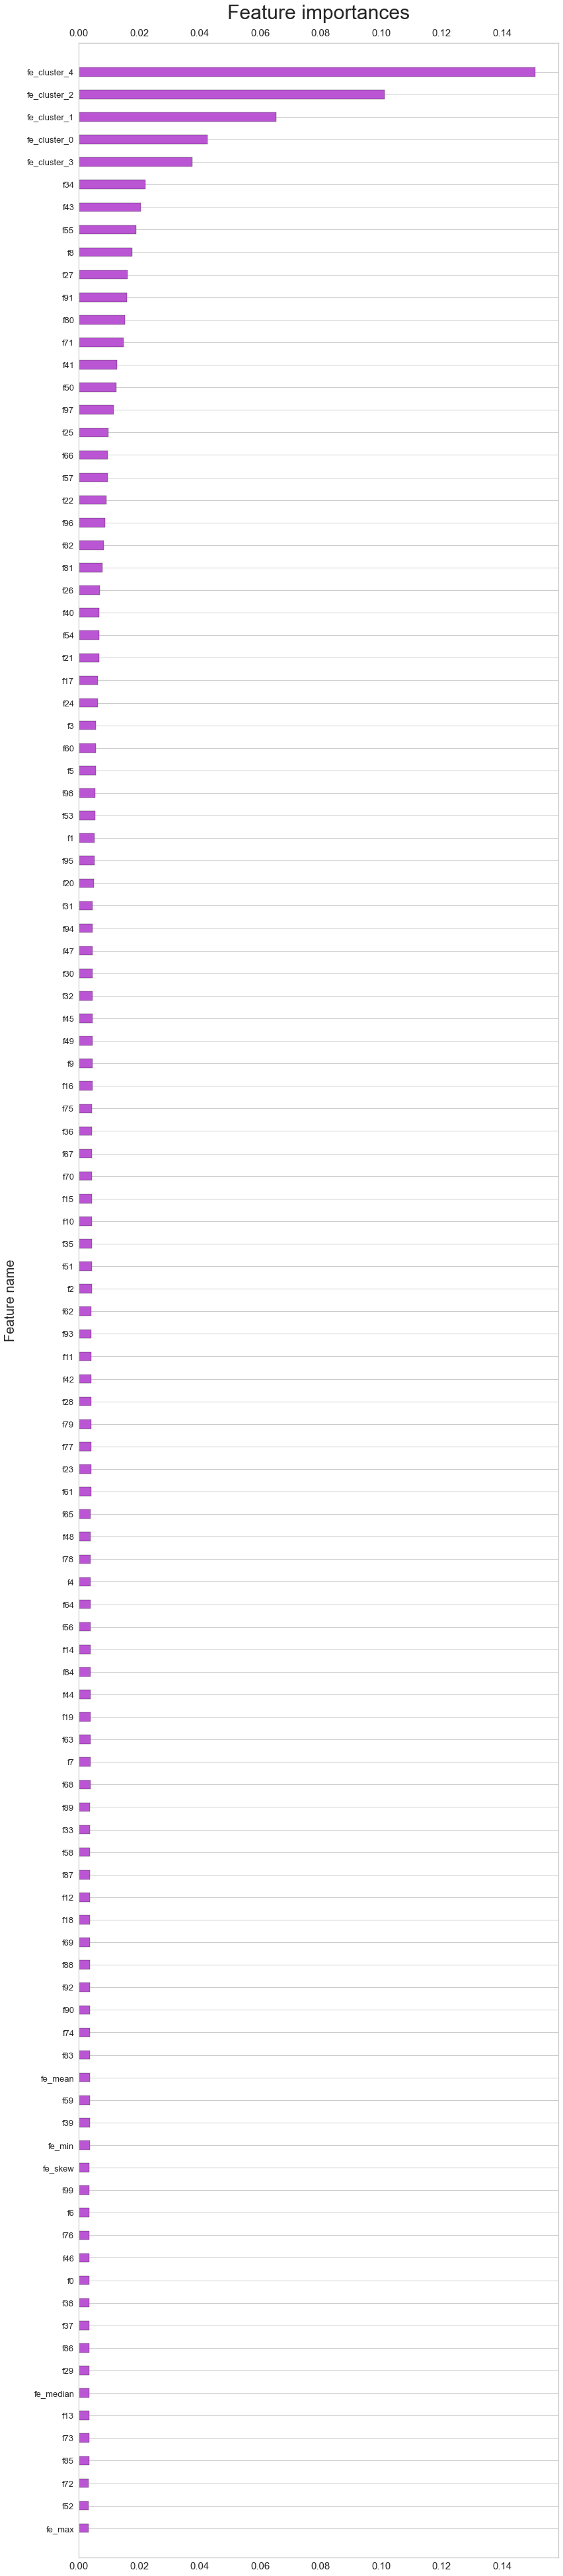

In [79]:
fig, ax = plt.subplots(figsize=(13, 70))
bars    = ax.barh(df["Feature"], 
                  df["Importance"], 
                  height    = 0.4,
                  color     = "mediumorchid", 
                  edgecolor = "black")

ax.set_title("Feature importances", fontsize=30, pad=15)
ax.set_ylabel("Feature name", fontsize=20, labelpad=15)
#ax.set_xlabel("Feature importance", fontsize=20, labelpad=15)
ax.set_yticks(df["Feature"])
ax.set_yticklabels(df["Feature"], fontsize=13)
ax.tick_params(axis="x", labelsize=15)
ax.grid(axis="x")

# Adicionando rótulos na parte superior
ax2 = ax.secondary_xaxis('top')
#ax2.set_xlabel("Feature importance", fontsize=20, labelpad=13)
ax2.tick_params(axis="x", labelsize=15)
ax.margins(0.05, 0.01)

# Inverter a direção do eixo y 
plt.gca().invert_yaxis()

<div class="alert alert-info" role="alert">
    
**`NOTA:`** <br>

Acima podemos observar que algumas das variáveis que criamos estão entre as 25 variáveis mais importantes para o modelo XGB, porém não gosto muito desse jeito de analisar as variáveis mais importantes, vamos utilizar o `Shap` que utilza vários métodos diferentes para encontrar as variáveis importantes. 
    
SHAP (SHapley Additive exPlanations) é uma abordagem teórica de jogos para explicar a saída de qualquer modelo de aprendizado de máquina, ver o [artigos](https://github.com/slundberg/shap#citations) para detalhes e citações.
    
</div>

### 4.2.4.1. SHAP Values
Explicar as previsões do modelo usando SHAP.

In [95]:
explainer = shap.Explainer(model_best)

#shap_values = explainer(X)

C extension was not built during install!


Exception: The passed model is not callable and cannot be analyzed directly with the given masker! Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8,
              num_parallel_tree=1, predictor='gpu_predictor',
              random_state=12359, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)

In [87]:
shap.plots.waterfall(shap_values[0],max_display=110)

NameError: name 'shap_values' is not defined

<div class="alert alert-info" role="alert">
    
**`NOTA:`** <br>
O gráfico acima mostra as variáveis e suas contribuições na predição do modelo, as variáveis que empurram a previsão para cima são mostradas em vermelho, e as que empurram o previsão para baixo são mostradas em azul.<br>
As variáveis que criamos que empurram a previsão para baixo são: e_mean, fe_max, fe_skew, vamos visualzar a mesma explicação utilizando o gráfico de força. 
</div>

In [88]:
shap.plots.force(shap_values[0])

NameError: name 'shap_values' is not defined

<div class="alert alert-info" role="alert"> 
    
Vamos dar uma olhda no resumo das das variáveis, o gráfico abaixo classifica os recursos pela soma das magnitudes dos valores de SHAP em todas as amostras e usa os valores de SHAP para mostrar a distribuição dos impactos que cada variável tem na predição do modelo. A cor representa o valor da variável (vermelho alto, azul baixo). 
    
</div>

In [89]:
shap.plots.beeswarm(shap_values)

NameError: name 'shap_values' is not defined

<div class="alert alert-info" role="alert">    
**`NOTA:`** <br>
O gráfico acima revela que as variáveis f34, f43 e f8 tem alto impacto na previsão do XGB.      
</div>

In [118]:
shap.plots.beeswarm(shap_values, max_display=111)

<div class="alert alert-info" role="alert">
    
Também podemos apenas pegar o valor absoluto médio dos valores de SHAP para cada variável para obter um gráfico de barra padrão:
</div>

In [64]:
shap.plots.bar(shap_values, max_display=111)

# <div class="alert alert-success"> 5. Conclusão </div>

<div class="alert alert-info" role="alert">    
Neste notebook criamos novas variáveis utilizando a clusterização e variáveis estatísticas, com a finalidade de ajudar os modelos a identificar padrões no dados para melhor as previsões, na validação realizada com XGB obtivemos uma melhora, porém nas submissões não tivemos melhora. <br>
    
Além da criação de novas variávies, utilizamos o SHAP Values para avaliar o impacto das novas variáveis e antigas nas previsões do modelo XGB, podemos destacar que as variáveis: **fe_mean, fe_max, fe_skew** que foram criadas tem impacto negativo nas predições, assim como outras variáveis puxam a predição para baixo, esse talvez seja o favor de não temos melhoria nas nossas submissões, sendo assim, são variáveis contidas a serem removidas do modelo. <br>
    
Um ponto importante que devemos destacar é que ainda não fizemos os ajuste de parametros e estamos trabalhando apenas com um predito (XGB), sendo assim, essas variáveis podem ter valor preditivos relevantes para outros classificadores, os quais vamos teste em outros notebooks.
    
Nos próximos notebooks vamos fazer o ajuste de parametros para os seguintes classificadores: 
- XGB
- LGBM; 
- CatBoost; 
- Rede Neural; 
- KNN;
- SVN; 
    
<br> 
    
A ideia é criar uma stacking, sendo assim, vamos salvar todos os modelos.     
    
<br>
    
Link notebook kaggle: https://www.kaggle.com/rogeriodelfim/tps-nov-2021-02-feature-engenniring-shap
    
</div>